## Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import geopandas as gpd
import contextily as ctx
pd.set_option('display.max_columns', None)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

folder_path = r'D:\WORK\FLOODNET\SensorData'

c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\cansu\.conda\envs\Data_Analysis\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Run this to combine CSVs into a single DF
If you already have the parquet files, skip this cell

In [ ]:

flood_files = [f for f in os.listdir( folder_path) if f.endswith('.csv')]

flood_data = pd.DataFrame()
for flood_file in flood_files:
    temp = pd.read_csv(os.path.join( folder_path , flood_file))
    flood_data = pd.concat( [flood_data, temp] )

flood_data['time'] = pd.to_datetime( flood_data['time'] )
flood_data.head()

### Load Parquet File
Parquet file contains all the flood sensor data.

In [2]:
# flood_data.to_parquet( os.path.join( folder_path, 'all_flood_data.parquet') )
flood_data = pd.read_parquet( os.path.join( folder_path, 'all_flood_data.parquet') )
flood_data.head(3)

,time,deployment_id,dev_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,batt_v,f_cnt,dist_mm,lat,lon,date_deployed,deploy_type,sensor_display_name,sensor_address_street,sensor_address_borough,sensor_address_neighborhood,nearest_weather_station,nearest_tidal_id,mounted_over,sensor_mount,sensor_id,sensor_name,max_precip_last_5min_mm_per_min,baro_pres_pa,relhumid_percent,snow_depth_mm,solar_insol_wm2,temp_c,wind_dir_deg,wind_speed_kmh,mhhw_mm,mllw_mm,navd88_mm
0,2022-10-01 00:00:08.314000+00:00,easily_cosmic_slug,fs-00010,0.0,0.0,0.0,4.092,70504.0,2356.0,40.809830,-73.948100,"December 12, 2021",pluvial,M - 126th St/7th Av,W 126th and Adam Clayton Powell Jr Blvd,Manhattan,Harlem,nyc-micronet-mhchel,None,Sidewalk,Streetsign Post,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-01 00:00:18.040000+00:00,handsome_violet_leech,fs-00025,0.0,0.0,0.0,4.074,4619.0,2798.0,40.695371,-73.794115,"June 10, 2022",pluvial,Q - 108th Ave/159th St,108 Ave and 159 St,Queens,South Jamaica,nyc-micronet-qnsozo,None,Sidewalk,Streetsign Post,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-01 00:00:19.736000+00:00,daily_happy_satyr,fs-00022,-130.0,0.0,0.0,4.126,243336.0,1632.0,40.591360,-73.809960,"December 10, 2021",pluvial,Q - Beach 84 St,Beach 84 St,Queens,Far Rockaway,nyc-micronet-qnsozo,usgs-tidal-01311850,Sidewalk,Fence,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


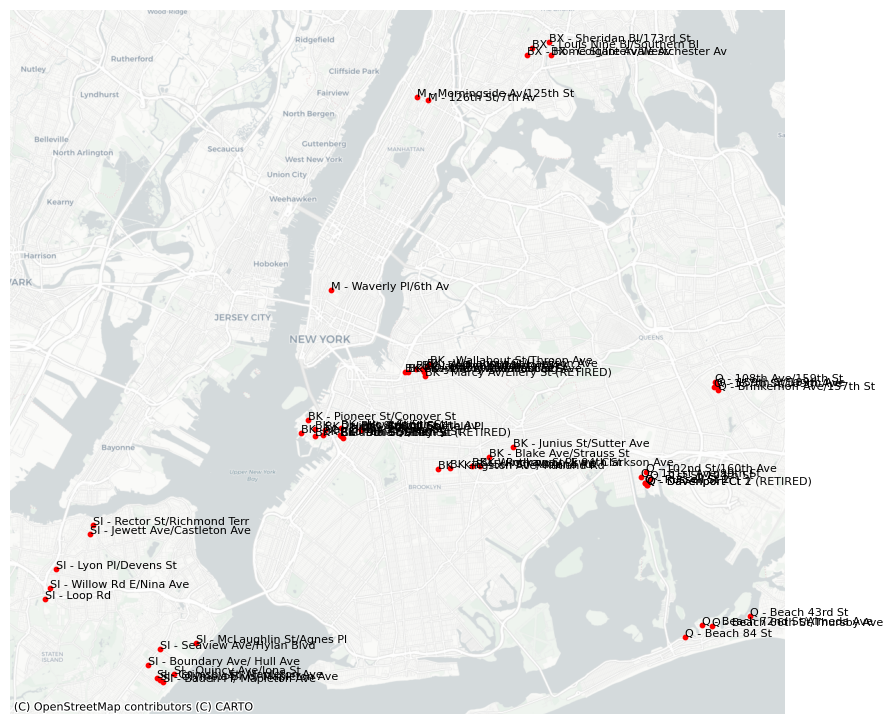

In [3]:
sensor_locations = flood_data.groupby('deployment_id').agg({
    'lat': 'first',
    'lon': 'first',
    'sensor_display_name': 'first'
})

sensor_geo = gpd.GeoDataFrame( sensor_locations, geometry=gpd.points_from_xy(sensor_locations.lon, sensor_locations.lat), crs=4326 )
sensor_geo = sensor_geo.to_crs(3857)
sensor_geo.plot( color='red', markersize=10, figsize=(10,10) )

# annotate the sensors by sensor_display_name
for idx, row in sensor_geo.iterrows():
    plt.annotate( row['sensor_display_name'], (row['geometry'].x, row['geometry'].y) , fontsize=8 )

ctx.add_basemap( plt.gca(), source=ctx.providers.CartoDB.Positron )
plt.axis('off');

In [4]:
flood_data = flood_data.drop(['dev_id','batt_v','f_cnt','dist_mm','sensor_address_street','deploy_type','date_deployed','sensor_address_neighborhood','sensor_address_borough','nearest_weather_station','nearest_tidal_id','mounted_over','sensor_mount'], axis=1 )
flood_data = flood_data.dropna( axis=1, how='all' )

# make time UTC unaware
flood_data['time'] = flood_data['time'].dt.tz_localize(None)

flood_data.head(3)

,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,sensor_display_name,sensor_id,sensor_name,max_precip_last_5min_mm_per_min,baro_pres_pa,relhumid_percent,snow_depth_mm,solar_insol_wm2,temp_c,wind_dir_deg,wind_speed_kmh,mhhw_mm,mllw_mm,navd88_mm
0,2022-10-01 00:00:08.314,easily_cosmic_slug,0.0,0.0,0.0,40.809830,-73.948100,M - 126th St/7th Av,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-01 00:00:18.040,handsome_violet_leech,0.0,0.0,0.0,40.695371,-73.794115,Q - 108th Ave/159th St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-01 00:00:19.736,daily_happy_satyr,-130.0,0.0,0.0,40.591360,-73.809960,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot a single sensors data for test

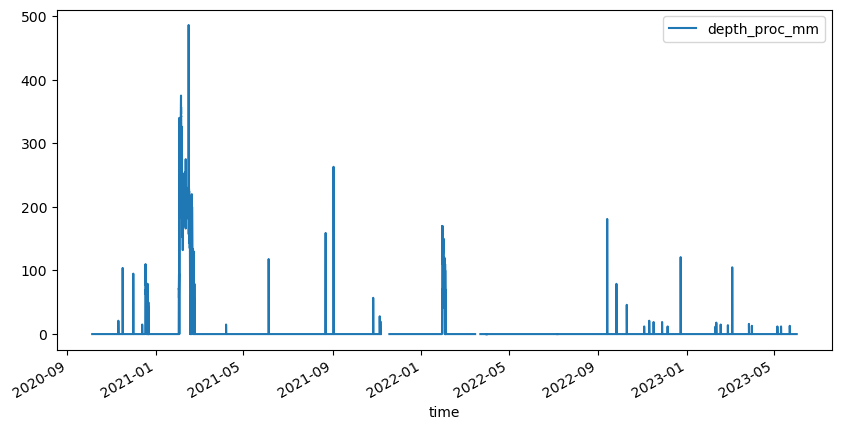

In [5]:
flood_data = flood_data.dropna( axis = 0 , subset = ['deployment_id'] )
flood_data[ flood_data['deployment_id'] == 'daily_new_falcon' ].plot( x = 'time' , y = 'depth_proc_mm' , figsize = (10,5) );

### Filter None value
Appr. 700K rows have `'depth_raw_mm','depth_filt_mm','depth_proc_mm'` as None.

In [6]:
print( flood_data.shape[0] , "vs." ,flood_data.dropna( axis = 0 , subset = ['depth_raw_mm','depth_filt_mm','depth_proc_mm'] ).shape[0] )

nones = flood_data[ flood_data['depth_raw_mm'].isnull() & flood_data['depth_filt_mm'].isnull() & flood_data['depth_proc_mm'].isnull() ]

flood_data = flood_data.drop( nones.index , axis = 0 )
nones['deployment_id'].value_counts().head()

10588952 vs. 9822685


vastly_saving_whale     359476
openly_driven_tarpon    249411
early_still_frog         39477
gladly_mint_snail        16545
jolly_tender_squid       15592
Name: deployment_id, dtype: int64

### Add neighborhoods CDTA's to DF

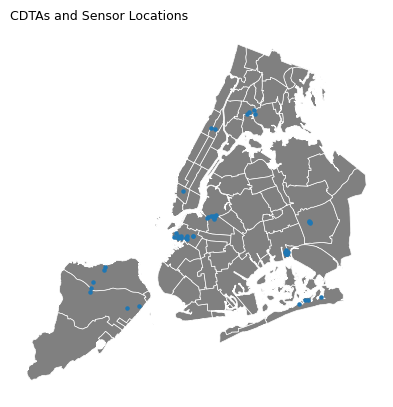

In [7]:
import geopandas as gpd

path = r"C:\Git_Repo\FloodAnalysis\DATA\NYCDTA_flood_reports_detections_join.geojson"
cdta = gpd.read_file(path)

unique_Sensors = flood_data.groupby('deployment_id').agg({
    'lat':'first',
    'lon':'first'
})

geo_sensors = gpd.GeoDataFrame(unique_Sensors, geometry=gpd.points_from_xy(unique_Sensors.lon, unique_Sensors.lat), crs=4326 )
geo_sensors = geo_sensors.to_crs('EPSG:2263')

fig,ax = plt.subplots()
geo_sensors.plot(ax=ax, markersize=5, zorder = 2 )
cdta.plot(ax=ax, ec='w', fc='grey', zorder = 1 , lw=0.5)
ax.axis('off')
ax.set_title('CDTAs and Sensor Locations', loc='left', fontsize=9 );

geo_sensors = geo_sensors.sjoin(cdta[['CDTAName','geometry']]).drop(['index_right','geometry','lat','lon'], axis=1)

all_data = flood_data.join(geo_sensors, on='deployment_id')

In [8]:
events_path = r"D:\WORK\FLOODNET\EventsData.xlsx"
events = pd.read_excel(events_path, sheet_name='All Events till 052023')

events = events[ events['Deployment_id'] != 'ugliest_cyan_elephant' ] # sensor on the water way 
events = events[ events['Class'] == 0 ].copy() # 0 is the code for floods

events['Start_time'] = pd.to_datetime(events['Start_time'])
events['End_time'] = pd.to_datetime(events['End_time'])

# drop NaT values and create Intervals
events = events.dropna(subset=['Start_time','End_time'])
events['Interval'] =  events.apply( lambda x: pd.Interval(x['Start_time'],x['End_time'],closed='both'),axis=1) 

events = events.drop(['Borough','Type', 'Deployment_Date','Latitude','Longitude','Address'], axis=1)
events = events.drop( events.columns[events.columns.str.contains('Unnamed')] ,axis=1) 
events.head()

,Deployment_id,Start_time,End_time,Duration,Minutes,Class,Interval
0,asleep_apricot_bedbug,2022-09-13 08:25:28,2022-09-13 08:46:44,00:21:16,21.266667,0,"[2022-09-13 08:25:28, 2022-09-13 08:46:44]"
25,big_pink_elephant,2023-03-31 09:49:44,2023-03-31 10:02:27,00:12:43,12.716667,0,"[2023-03-31 09:49:44, 2023-03-31 10:02:27]"
34,big_pink_elephant,2023-04-23 03:19:43,2023-04-23 03:46:06,00:26:23,26.383333,0,"[2023-04-23 03:19:43, 2023-04-23 03:46:06]"
35,big_pink_elephant,2023-04-30 21:24:03,2023-05-01 01:58:11,04:34:08,274.133333,0,"[2023-04-30 21:24:03, 2023-05-01 01:58:11]"
125,blue_eyed_tiger,2023-04-30 21:22:03,2023-04-30 21:36:02,00:13:59,13.983333,0,"[2023-04-30 21:22:03, 2023-04-30 21:36:02]"


In [15]:
# 2022-12-23 10:00:47	 2022-12-23 16:19:24
display(
    events[ (events['Deployment_id'] == 'daily_happy_satyr') & (events['Start_time'] == pd.to_datetime('2022-12-23 10:00:47')) ]
)

display(
    all_data[ (all_data['deployment_id'] == 'daily_happy_satyr') & (all_data['time'] > pd.to_datetime('2022-12-23 10:00:47')) & (all_data['time'] < pd.to_datetime('2022-12-23 16:19:24'))  ].head()
)


,Deployment_id,Start_time,End_time,Duration,Minutes,Class,Interval
1144,daily_happy_satyr,2022-12-23 10:00:47,2022-12-23 16:19:24,06:18:37,378.616667,0,"[2022-12-23 10:00:47, 2022-12-23 16:19:24]"


,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,sensor_display_name,sensor_id,sensor_name,max_precip_last_5min_mm_per_min,baro_pres_pa,relhumid_percent,snow_depth_mm,solar_insol_wm2,temp_c,wind_dir_deg,wind_speed_kmh,mhhw_mm,mllw_mm,navd88_mm,CDTAName
519626,2022-12-23 10:02:59.549,daily_happy_satyr,12.0,12.0,12.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation)
519771,2022-12-23 10:11:22.604,daily_happy_satyr,75.0,75.0,75.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation)
519866,2022-12-23 10:16:37.830,daily_happy_satyr,119.0,119.0,119.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation)
520266,2022-12-23 10:38:40.880,daily_happy_satyr,365.0,365.0,365.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation)
520297,2022-12-23 10:40:46.008,daily_happy_satyr,385.0,385.0,385.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation)


### Plot flood events  
This is only for checking. Each grey bar is a flood event

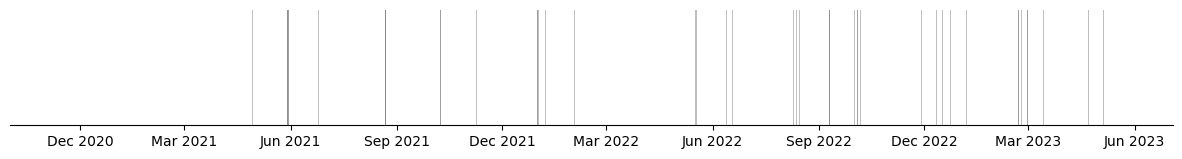

In [16]:
from matplotlib import dates as mdates

fig,ax = plt.subplots(figsize=(15,1.5))
events.apply( lambda x: ax.axvspan(x['Interval'].left, x['Interval'].right, facecolor='grey', edgecolor=None, alpha=0.5) , axis=1 )

# place x tick every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks([])
ax.set_ylabel('');

### Remove Non-Flood Events
- Create time intervals for each flood event.
- For each flood event, check if a sensor measurement is within the interval bounds.
- Assign 0 for measurements that are outside bounds in a new columns called `clean_depth`
- `smooth_depth_in` is in inches

In [17]:
import numpy as np

all_data['During Flood'] = False
print( events.shape[0] , 'events will be tested' )

for event_interval,sensor_id in zip(events['Interval'].values,events['Deployment_id'].values ):
    all_data.loc[ 
        (all_data['time'].between(event_interval.left, event_interval.right)) & 
        (all_data['deployment_id'] == sensor_id) , 
        'During Flood'
        ] = True
    
filtered_data = all_data.copy()
filtered_data['clean_depth'] = np.where( filtered_data['During Flood'] == True , filtered_data['depth_proc_mm'] , 0 )
filtered_data['smooth_depth_in'] = filtered_data['clean_depth'] / 25.4

filtered_data[ filtered_data['During Flood']==True ].head(3)

310 events will be tested


,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,sensor_display_name,sensor_id,sensor_name,max_precip_last_5min_mm_per_min,baro_pres_pa,relhumid_percent,snow_depth_mm,solar_insol_wm2,temp_c,wind_dir_deg,wind_speed_kmh,mhhw_mm,mllw_mm,navd88_mm,CDTAName,During Flood,clean_depth,smooth_depth_in
15097,2022-10-01 15:58:23.543,daily_happy_satyr,20.0,20.0,0.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),True,0.0,0.000000
15394,2022-10-01 16:17:18.756,daily_happy_satyr,40.0,40.0,40.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),True,40.0,1.574803
15610,2022-10-01 16:30:57.353,daily_happy_satyr,70.0,70.0,70.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),True,70.0,2.755906


In [18]:
display(
    filtered_data[ (filtered_data['deployment_id'] == 'daily_happy_satyr') & (filtered_data['time'] > pd.to_datetime('2022-12-23 10:00:47')) & (filtered_data['time'] < pd.to_datetime('2022-12-23 16:19:24'))  ].head()
)


,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,sensor_display_name,sensor_id,sensor_name,max_precip_last_5min_mm_per_min,baro_pres_pa,relhumid_percent,snow_depth_mm,solar_insol_wm2,temp_c,wind_dir_deg,wind_speed_kmh,mhhw_mm,mllw_mm,navd88_mm,CDTAName,During Flood,clean_depth,smooth_depth_in
519626,2022-12-23 10:02:59.549,daily_happy_satyr,12.0,12.0,12.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),True,12.0,0.472441
519771,2022-12-23 10:11:22.604,daily_happy_satyr,75.0,75.0,75.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),True,75.0,2.952756
519866,2022-12-23 10:16:37.830,daily_happy_satyr,119.0,119.0,119.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),True,119.0,4.685039
520266,2022-12-23 10:38:40.880,daily_happy_satyr,365.0,365.0,365.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),True,365.0,14.370079
520297,2022-12-23 10:40:46.008,daily_happy_satyr,385.0,385.0,385.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),True,385.0,15.157480


In [19]:
# Make filtered data time UTC then convert to America/New_York
filtered_data['time_NY'] = filtered_data['time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')

## PLOTS

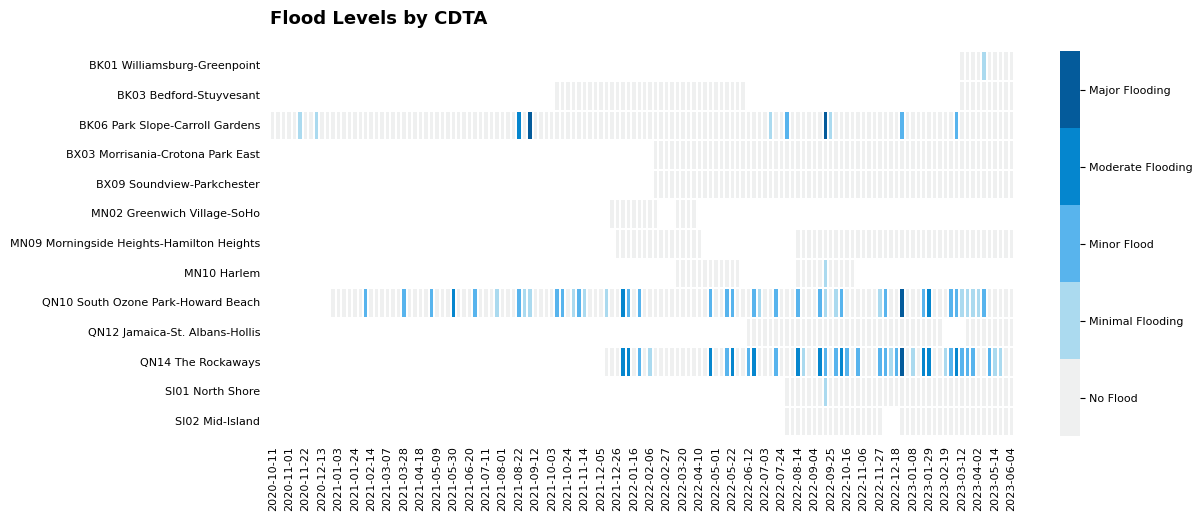

In [21]:
# ---- FORMAT & PLOT ----

# Segmented Color Map
def make_Ramp( ramp_colors ): 
    from colour import Color
    # from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    color_ramp = ListedColormap( ramp_colors )
    return color_ramp

custom_ramp = make_Ramp( ['#EFF0F0',"#ABDAEF","#58B4ED", '#0586CE', '#045B9B'] ) 
values = ['No Flood', 'Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']

filtered_data['smooth_depth_cut'] = pd.cut(
    filtered_data['smooth_depth_in'],
    bins=[-1, 0.25, 4, 12, 24, 1000 ],
    labels=[ 0, 1, 2, 3, 4]
)

# pivot to get max
pt = pd.pivot_table(
    data = filtered_data.sort_values('CDTAName'),
    columns = pd.Grouper(key='time_NY', freq='1W'),
    index = 'CDTAName',
    values='smooth_depth_cut',
    aggfunc='max'
)

# Format Columns - Time format
pt.columns = pt.columns.strftime('%Y-%m-%d')
pt.index = [x.split(" (")[0] for x in pt.index]

import seaborn as sns
plt.figure( figsize=(12, 5) )
# ---- Heatmap ----
ax = sns.heatmap(
    pt.astype(float),
    linewidths=0.025,
    linecolor='white',
    square=False,
    cmap = custom_ramp,
    mask=pt.isnull(),
)

ax.set_facecolor('#FFFFFF') # No Data is White
ax.tick_params( axis='both', left=False, bottom=False, labelsize=8 )

# Simplify the colors bar
n = len(values)
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels( values )
colorbar.ax.tick_params(labelsize=8)                                        

plt.xlabel('')
plt.ylabel('')
# plt.savefig( r'D:\WORK\FLOODNET\VISUALS\CDTA_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.title( "Flood Levels by CDTA", fontsize=13, fontweight='bold', ha = 'left', x=0, y=1.05)
plt.show();

### Choose which sensor you want to work with

In [22]:
t = filtered_data.dropna(subset='sensor_display_name')
t[ t['sensor_display_name'].str.contains('Beach')]['CDTAName'].values[0]

'QN14 The Rockaways (CD 14 Approximation)'

### Filter data to a CDTA

In [23]:
cdta_data = filtered_data.dropna(subset=['CDTAName'],axis=0)
cdta_data = cdta_data[ cdta_data['CDTAName'].str.contains("QN14") ].copy() 
cdta_data.head(3)

,time,deployment_id,depth_raw_mm,depth_filt_mm,depth_proc_mm,lat,lon,sensor_display_name,sensor_id,sensor_name,max_precip_last_5min_mm_per_min,baro_pres_pa,relhumid_percent,snow_depth_mm,solar_insol_wm2,temp_c,wind_dir_deg,wind_speed_kmh,mhhw_mm,mllw_mm,navd88_mm,CDTAName,During Flood,clean_depth,smooth_depth_in,time_NY,smooth_depth_cut
23,2022-10-01 00:01:22.245,daily_happy_satyr,-10.0,0.0,0.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),False,0.0,0.0,2022-09-30 20:01:22.245000-04:00,0
264,2022-10-01 00:16:05.731,daily_happy_satyr,-130.0,0.0,0.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),False,0.0,0.0,2022-09-30 20:16:05.731000-04:00,0
460,2022-10-01 00:28:39.559,daily_happy_satyr,-10.0,0.0,0.0,40.59136,-73.80996,Q - Beach 84 St,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QN14 The Rockaways (CD 14 Approximation),False,0.0,0.0,2022-09-30 20:28:39.559000-04:00,0


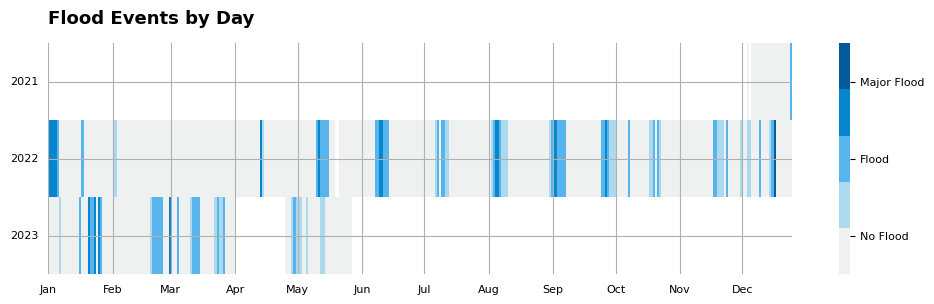

In [24]:
cdta_data['year'] = cdta_data['time_NY'].dt.year

# Get week number
cdta_data['week'] = cdta_data['time_NY'].dt.dayofyear
cdta_data['month'] = cdta_data['time_NY'].dt.month

cdta_daily =pd.pivot_table(
    data = cdta_data,
    columns = ['month','week'],
    index = 'year',
    values= 'smooth_depth_cut',
    aggfunc='max'
).astype( float )

plt.figure( figsize=(12,3) )
ax = sns.heatmap( cdta_daily, cmap= custom_ramp, lw=0.0025 )
ax.tick_params( axis='both', left=False, bottom=False, labelsize=8 )

# Legend
values = ['No Flood', 'Flood', 'Major Flood']
n = len(values)

colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels( values )
colorbar.ax.tick_params(labelsize=8)    

# adjust tick frequency
import matplotlib.dates as mdates
ax.xaxis.set_major_locator( mdates.MonthLocator(interval=1) )
ax.xaxis.set_major_formatter( mdates.DateFormatter('%b') )

# x-tick labels, rotate
plt.xticks(rotation=0)
plt.grid(True)

# Rotate y labels
plt.ylabel('')
plt.xlabel('')
plt.yticks(rotation=0)
plt.title( "Flood Events by Day", fontsize=13, fontweight='bold', ha = 'left', x=0, y=1.05);
# plt.savefig( r'D:\WORK\FLOODNET\VISUALS\RH_heatmap.pdf', dpi=300, bbox_inches='tight')

### Plot a single flood event for Hoyt Sensor

In [27]:
# Remove UTC awareness to filter easily
filtered_data['time_NY'] = filtered_data['time_NY'].dt.tz_localize(None)

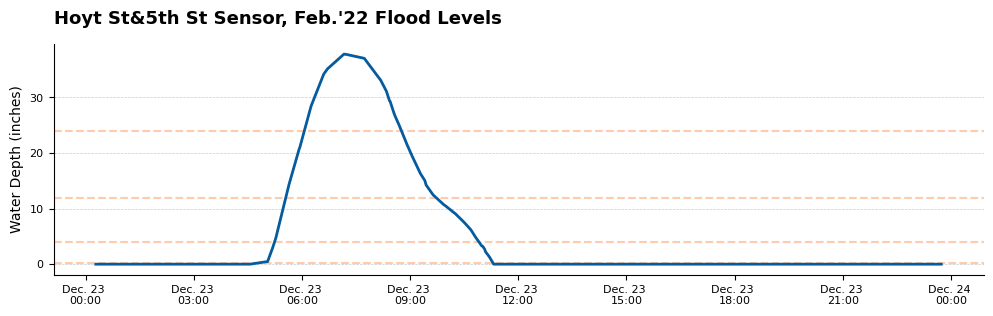

In [29]:

hoyt_data = filtered_data[
    (filtered_data['deployment_id'] == 'daily_happy_satyr') &
    (filtered_data['time_NY'] < pd.to_datetime('2022-12-23 23:59:59') ) &
    (filtered_data['time_NY'] > pd.to_datetime('2022-12-23 00:00:00') )
    ].copy()

hoyt_data = hoyt_data[ ~hoyt_data['depth_proc_mm'].isnull() ].reset_index()

plt.figure( figsize=(12, 3) )
sns.lineplot(
    data = hoyt_data,
    x = 'time_NY',
    y = 'smooth_depth_in',
    lw = 2,
    color = '#045B9E',
    zorder = 2
)

# Annotate over the axhline
colors = ['#FCD695','#FFB533','#FC751A','#E80000']
values = ['Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']
bins=[0.25,4, 12, 24 ]

for (depth, flood_level, color) in zip(bins, values, colors):
    plt.axhline(depth, color ='#FE9B5D', alpha=0.5 , lw=1.5, ls ='--' , zorder = 1)
    plt.annotate( flood_level, xy = (hoyt_data['time'].max(),depth+0.1), ha='right', va = 'bottom' , color = color, fontsize=8 )

# hide every 2nd xtick
plt.xticks( fontsize=8 )
plt.yticks( fontsize=8 )

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b. %d \n%H:%M'))

# Grey overlays for non 0 values
def group_consecutive(data):
    import numpy as np
    return np.split(data, np.where(np.diff(data) != 1)[0]+1)

hoyt_data['order'] = [i for i in range(len(hoyt_data))]
non_zero = hoyt_data[ hoyt_data['smooth_depth_in'] > 0 ]

for count,nz in enumerate(group_consecutive(non_zero['order'].values)):
    if len(nz) > 300:
        nz_time_min = hoyt_data['time'].iloc[nz[0]]
        nz_time_max = hoyt_data['time'].iloc[nz[-1]]
        # filter data by dates
        nz_data = hoyt_data[ (hoyt_data['time'] >= nz_time_min) & (hoyt_data['time'] <= nz_time_max) ]
        f_max = nz_data['smooth_depth_in_2'].max()     
        plt.axvspan( nz_time_min, nz_time_max, fc='#333', ec=None, alpha=0.15, zorder=0 )
        plt.annotate( 
            "Flood Duration: {}days \nMax Depth: {}in. ".format( (pd.to_datetime(nz_time_max) - pd.to_datetime(nz_time_min)).days, round(f_max,1) ) ,
            xy = ( 
                nz_time_max , 
                hoyt_data['smooth_depth_in_2'].max() - (count*0.5)
                ), ha='right', va = 'top' , color = '#333', fontsize=8 )
        
plt.grid( axis='y', alpha=0.25 , zorder=-1 , lw=0.5, ls='--', color='#333')
plt.title( "Hoyt St&5th St Sensor, Feb.'22 Flood Levels" , fontsize=13, fontweight='bold', ha = 'left', x=0, y=1.05)
plt.ylabel( "Water Depth (inches)" )
plt.xlabel( "" )
sns.despine()
# plt.savefig( r'D:\WORK\FLOODNET\VISUALS\Hoyt5_timeseries.pdf', dpi=300, bbox_inches='tight')


In [50]:
events_path = r"D:\WORK\FLOODNET\EventsData.xlsx"
events = pd.read_excel(events_path, sheet_name='All Events till 052023')

events = events[ events['Deployment_id'] != 'ugliest_cyan_elephant' ] # sensor on the water way 
# events = events[ events['Class'] == 0 ].copy() # 0 is the code for floods

events['Start_time'] = pd.to_datetime(events['Start_time'])
events['End_time'] = pd.to_datetime(events['End_time'])

# drop NaT values and create Intervals
events = events.dropna(subset=['Start_time','End_time'])
events['Interval'] =  events.apply( lambda x: pd.Interval(x['Start_time'],x['End_time'],closed='both'),axis=1) 

events = events.drop(['Borough','Type', 'Deployment_Date','Latitude','Longitude','Address'], axis=1)
events = events.drop( events.columns[events.columns.str.contains('Unnamed')] ,axis=1) 
events.head()

events[ events['Deployment_id'] == 'mainly_whole_slug' ]

,Deployment_id,Start_time,End_time,Duration,Minutes,Class,Interval
3545,mainly_whole_slug,2022-08-16 23:54:02,2022-08-16 23:56:22,00:02:20,2.333333,1,"[2022-08-16 23:54:02, 2022-08-16 23:56:22]"
3546,mainly_whole_slug,2022-08-27 02:27:01,2022-08-27 02:29:11,00:02:10,2.166667,1,"[2022-08-27 02:27:01, 2022-08-27 02:29:11]"
3547,mainly_whole_slug,2022-09-12 15:38:15,2022-09-12 15:42:29,00:04:14,4.233333,1,"[2022-09-12 15:38:15, 2022-09-12 15:42:29]"
3548,mainly_whole_slug,2022-09-21 18:42:03,2022-09-21 18:44:17,00:02:14,2.233333,1,"[2022-09-21 18:42:03, 2022-09-21 18:44:17]"
3549,mainly_whole_slug,2022-10-07 08:46:14,2022-10-07 08:49:28,00:03:14,3.233333,1,"[2022-10-07 08:46:14, 2022-10-07 08:49:28]"
3550,mainly_whole_slug,2022-10-20 01:13:47,2022-10-20 01:17:59,00:04:12,4.200000,1,"[2022-10-20 01:13:47, 2022-10-20 01:17:59]"
3551,mainly_whole_slug,2022-10-25 23:02:38,2022-10-25 23:05:04,00:02:26,2.433333,1,"[2022-10-25 23:02:38, 2022-10-25 23:05:04]"
3552,mainly_whole_slug,2022-11-02 22:40:47,2022-11-02 22:42:49,00:02:02,2.033333,1,"[2022-11-02 22:40:47, 2022-11-02 22:42:49]"
3553,mainly_whole_slug,2022-11-11 01:33:00,2022-11-11 01:36:20,00:03:20,3.333333,1,"[2022-11-11 01:33:00, 2022-11-11 01:36:20]"
3554,mainly_whole_slug,2022-11-11 04:18:49,2022-11-11 04:22:07,00:03:18,3.300000,1,"[2022-11-11 04:18:49, 2022-11-11 04:22:07]"


In [21]:
import seaborn as sns

# definition to group consecutive values in a list for order variable
def group_consecutive(data):
    import numpy as np
    return np.split(data, np.where(np.diff(data) != 1)[0]+1)

# Simplify the data to 3 hour means. 
time_data = cdta_data.groupby( ['deployment_id',pd.Grouper(key='time',freq="3H")] ).agg({
    'smooth_depth_in':'mean',
    'sensor_display_name':'first',
    }).reset_index()


time_data = time_data.dropna(axis=0)
time_data = time_data[ ~time_data['sensor_display_name'].str.contains("RET") ] # Remvoed Retired Sensors

time_data = time_data.groupby('deployment_id').filter(lambda x: sum(x['smooth_depth_in']) > 0 ) # Remove sensors that never recorded a flood

fig,axs = plt.subplots(nrows=time_data['deployment_id'].nunique(),figsize=(12,6), sharex=True, sharey=True )

for count,id in enumerate(time_data['deployment_id'].unique()):
    ax = axs[count]
    temp = time_data[time_data['deployment_id']==id].copy()

    print( temp['smooth_depth_in'].max() , temp['sensor_display_name'].values[0] )
    ax.plot(
        temp['time'], 
        temp['smooth_depth_in'], 
        lw=1 , zorder=count+1,
        color = '#045B9E')

    ax.set_ylabel( temp['sensor_display_name'].values[0].split(" - ")[1] , rotation=0, ha='left')
    # move the y label to the left
    ax.yaxis.set_label_coords(-0.1,0)
    sns.despine( bottom = True, left = True, right=True, ax=ax )
    ax.patch.set_alpha(0)

    #remove xticks
    ax.set_yticks([])
    ax.tick_params(axis='x', bottom=False)
    ax.grid(axis='x', alpha=0.25 , zorder=-1 , lw=0.75, ls='--', color='#333')

    # Iterate over events and filter by id
    single_events = events[events['Deployment_id']==id].copy()
    single_events['Start_time'] = pd.to_datetime(single_events['Start_time'])
    single_events['End_time'] = pd.to_datetime(single_events['End_time'])
    if single_events.shape[0] > 0:
        try:
            for count,event in single_events.iterrows():
                ax.axvspan(event['Start_time'], event['End_time'], alpha=0.2, fc='grey', ec='grey', lw=0.1, zorder=0 )
        except:
            print("{} - {}".format( single_event['Start_time'], single_event['End_time']))


plt.tight_layout( h_pad= 0 , w_pad=0 )
# plt.savefig( r'D:\WORK\FLOODNET\VISUALS\RH_timeseries.pdf', dpi=300, bbox_inches='tight')
plt.show()


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x600 with 0 Axes>

In [ ]:
print( "Sensors containing the key word: ", ", ".join( cdta_data[ cdta_data['sensor_display_name'].str.contains('Russel') ]['deployment_id'].unique()) )

Sensors containing the key word:  easily_dear_mouse, duly_pro_vervet


C:\Users\cansu\AppData\Local\Temp\ipykernel_8048\3130667000.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] , rotation=0, fontsize=11, ha='left' )


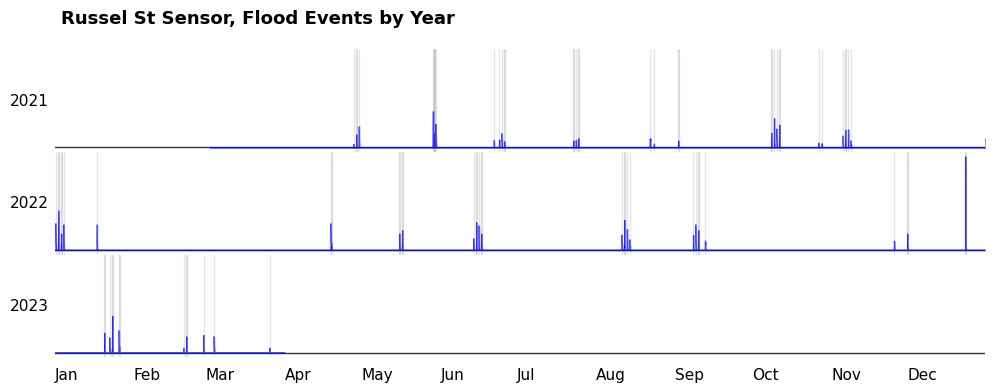

In [ ]:
import seaborn as sns

sensor_name = 'easily_dear_mouse'

single_sensor_data = cdta_data[ (cdta_data['deployment_id'] == sensor_name) ].copy()

single_sensor_data = single_sensor_data[ ~single_sensor_data['depth_proc_mm'].isnull() ].reset_index()
single_sensor_data = single_sensor_data[['time','smooth_depth_in']]

single_sensor_data['year'] = single_sensor_data['time'].dt.year

# --- Events
this_sensor_events = events[ events['Deployment_id'] == sensor_name ]

fig,axs = plt.subplots ( nrows=single_sensor_data['year'].nunique() , figsize=(12,4), sharey=True )

for count,year in enumerate(sorted(single_sensor_data['year'].unique())):
    
    ax = axs[count]

    t = single_sensor_data[ single_sensor_data['year'] == year ].copy()
    t = t.sort_values('time')

    ax.fill_between(
        t['time'],
        t['smooth_depth_in'],
        color = 'blue',
        alpha = 0.5,
        zorder = 3
    )

    ax.plot(
        t['time'],
        t['smooth_depth_in'],
        color = 'blue',
        lw=0.2,
        zorder = 4
    )

    # EVENTS
    annual_this_sensor_events = this_sensor_events[ this_sensor_events['Start_time'].dt.year == year ].copy()
    annual_this_sensor_events['Start_time'] = pd.to_datetime( annual_this_sensor_events['Start_time'] )
    annual_this_sensor_events['End_time'] = pd.to_datetime( annual_this_sensor_events['End_time'] )

    annual_this_sensor_events.apply( lambda x: ax.axvspan( x['Start_time'],x['End_time'], ymin=0 , facecolor = 'grey', edgecolor='grey', alpha=0.2, zorder=2 ), axis=1  )

    # MONTHS
    ax.xaxis.set_major_locator( mdates.MonthLocator(interval=1) )
    # ax.grid( axis='x', lw=0.5, alpha=0.5 )

    ax.set_xlim( pd.to_datetime( f'{year}-01-01'), pd.to_datetime( f'{year}-12-31') )
    ax.set_ylabel( year , rotation=0, ha='right', va='center', fontsize=11 )

    # x-Axis
    ax.plot( [pd.to_datetime( f'{year}-01-01'), pd.to_datetime( f'{year}-12-31')], [0,0], color = '#333',lw=1,zorder=0 )

    if count != single_sensor_data['year'].nunique()-1:
        sns.despine( bottom = True, left = True, right=True, ax=ax )
        ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False )
    else:
        sns.despine( bottom = True, left = True, right=True, ax=ax )
        ax.tick_params(axis='both', bottom=False, left=False, labelbottom=True, labelleft=False )

        # x-Axis plot short month names
        ax.set_xticklabels( ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] , rotation=0, fontsize=11, ha='left' )


# set title to plot
plt.suptitle( "Russel St Sensor, Flood Events by Year", fontsize=13, fontweight='bold', ha = 'left', x=0.13 )

plt.subplots_adjust(hspace=0)
# plt.savefig( r'D:\WORK\FLOODNET\VISUALS\Russel_events.pdf' );